## Intervening gpt-oss

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stanfordnlp/pyvene/blob/main/tutorials/basic_tutorials/gpt-oss.ipynb)

In [1]:
__author__ = "Zhengxuan Wu and Aryaman Arora"
__version__ = "08/05/2025"

### Overview

This tutorial provides you the starter-kit for performing interventions on `gpt-oss` model with a few lines of code.

In [ ]:
try:
    # This library is our indicator that the required installs
    # need to be done.
    import pyvene

except ModuleNotFoundError:
    !pip install git+https://github.com/stanfordnlp/pyvene.git

In [2]:
import pandas as pd
import torch
from torch import nn
import pyvene
from pyvene import top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

lsm = nn.LogSoftmax(dim=2)
sm = nn.Softmax(dim=2)

def embed_to_distrib(model, embed, log=False, logits=False):
    """Convert an embedding to a distribution over the vocabulary"""
    with torch.inference_mode():
        vocab = torch.matmul(embed, model.lm_head.weight.t())
        if logits:
            return vocab
        return lsm(vocab) if log else sm(vocab)

### Factual recall

In [ ]:
config, tokenizer, gpt_oss = pyvene.create_gpt_oss()
gpt_oss = gpt_oss.to("cuda")

base = "The capital of Spain is"
source = "The capital of Italy is"
inputs = [
    tokenizer(base, return_tensors="pt").to("cuda"), 
    tokenizer(source, return_tensors="pt").to("cuda")
]
print(base)
res = gpt_oss(**inputs[0], output_hidden_states=True)
distrib = embed_to_distrib(gpt_oss, res.hidden_states[-1][:, -1:], logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)
print()
print(source)
res = gpt_oss(**inputs[1], output_hidden_states=True)
distrib = embed_to_distrib(gpt_oss, res.hidden_states[-1][:, -1:], logits=False)
top_vals(tokenizer, distrib[0][-1], n=10)

The capital of Spain is
_Madrid              0.7109375
_Barcelona           0.042724609375
_"                   0.027587890625
_**                  0.01904296875
_not                 0.0157470703125
_                    0.01080322265625
:                    0.01080322265625
_the                 0.01019287109375
_a                   0.0074462890625
_Spain               0.006988525390625

The capital of Italy is
_Rome                0.8125
_"                   0.02783203125
_**                  0.01025390625
_the                 0.0096435546875
:                    0.00799560546875
_a                   0.00799560546875
_not                 0.00750732421875
_                    0.00750732421875
_'                   0.0037689208984375
_known               0.0035400390625


In [7]:
def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = inputs[0]
sources = [inputs[1]]

### Patch Patching on Position-aligned Tokens
We path patch on two modules on each layer:
- [1] MLP output (the MLP output will be from another example)
- [2] MHA input (the self-attention module input will be from another module)

In [21]:
# should finish within 1 min with a standard 12G GPU
tokens = tokenizer.encode(" Madrid Rome")

data = []
for layer_i in range(gpt_oss.config.num_hidden_layers):
    config = simple_position_config(type(gpt_oss), "mlp_output", layer_i)
    intervenable = IntervenableModel(config, gpt_oss)
    for pos_i in range(len(base.input_ids[0])):
        base["output_hidden_states"] = True
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt_oss, counterfactual_outputs.hidden_states[-1][:, -1:], logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    config = simple_position_config(type(gpt_oss), "attention_input", layer_i)
    intervenable = IntervenableModel(config, gpt_oss)
    for pos_i in range(len(base.input_ids[0])):
        base["output_hidden_states"] = True
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        distrib = embed_to_distrib(
            gpt_oss, counterfactual_outputs.hidden_states[-1][:, -1:], logits=False
        )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)

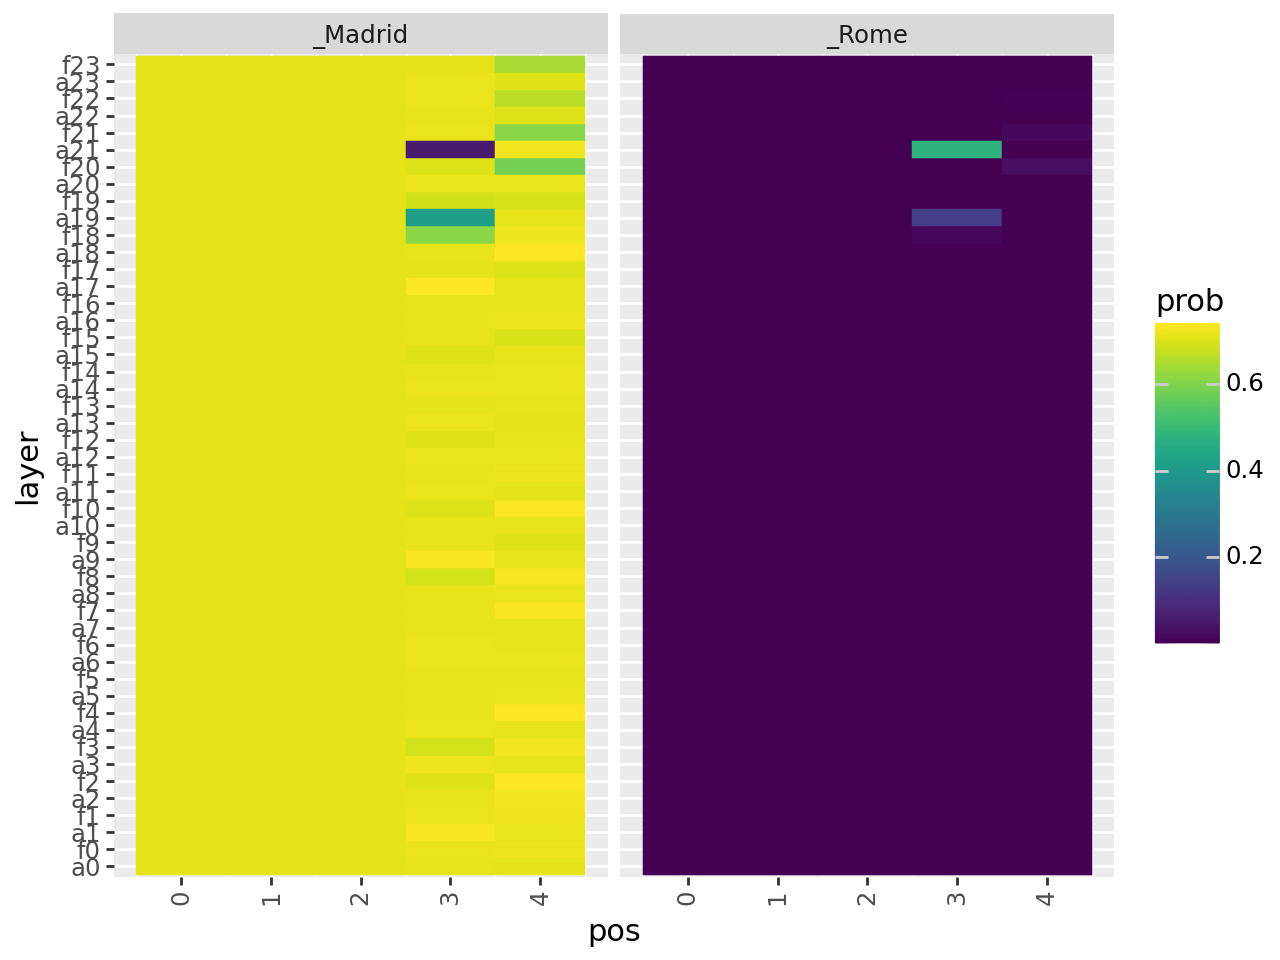

In [26]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(gpt_oss.config.num_hidden_layers - 1, -1, -1):
    nodes.append(f"f{l}")
    nodes.append(f"a{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
g